*This notebook gets the number of atlas v3 residential and samknows residential probes for each ASN (having equal or more than 10 probes) which ran month-long measurements. It uses this data to plot the distribution of ^ probes within each AS.*
- - - 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sqlite3
import pandas as pd
import requests
import ipaddress
import time

In [3]:
DB_LOCATION = 'lastmile.db'

In [4]:
RA_PROBE = 'ra_probe'
RA_PROBE_API = 'ra_probe_api'
RA_ASN = 'ra_asn'
RA_ONE_OFF_EXTENSIONS = 'ra_one_off_extensions'
RA_LATENCIES_AGG = 'ra_latencies_agg'

In [5]:
METADATA_SNAPSHOT_EXTENSIONS = 'metadata_snapshot_extensions'
SK_ONE_OFF_EXTENSIONS = 'sk_one_off_extensions'
SK_ASN = 'sk_asn'

In [6]:
con = sqlite3.connect(DB_LOCATION)

In [7]:
query_sk = ''' SELECT     s.asn
                        , s.asn_holder_name
                        , s.asn_access_type
                        , count(distinct(oe.probeid)) as probes
                                                                                      
               FROM       %s                            as   se
                        , %s                            as   oe
                        , %s                            as   s 

               WHERE      se.probeid                    =    oe.probeid
               AND        se.asn                        =    s.asn     
               AND        oe.if_residential             =    1         
                                                       

               GROUP BY s.asn
               HAVING probes >= 10
               
               ORDER BY asn_access_type, probes DESC               
               
           '''%(   METADATA_SNAPSHOT_EXTENSIONS
                 , SK_ONE_OFF_EXTENSIONS
                 , SK_ASN
               )

df_sk = pd.read_sql(query_sk, con)

In [8]:
query_ra = '''SELECT    s.asn             
                      , s.asn_holder_name
                      , s.asn_access_type
                      , count(distinct(agg.probeid)) as probes

               FROM   %s                             as  agg
                    , %s                             as  api
                    , %s                             as  s
                    , %s                             as  hardware
                    , %s                             as  ext

               WHERE     agg.probeid                  =  api.probeid
               AND       agg.probeid                  =  hardware.probeid
               AND       agg.probeid                  =  ext.probeid

               AND       api.asn_v4                   =  s.asn
               AND       hardware.hardware_version    =  'v3'
               AND       ext.if_residential           =  1



               GROUP BY s.asn
               HAVING probes >= 10
               
               ORDER BY asn_access_type, probes DESC

            '''%(  RA_LATENCIES_AGG
                 , RA_PROBE_API
                 , RA_ASN
                 , RA_PROBE
                 , RA_ONE_OFF_EXTENSIONS
                )

df_ra = pd.read_sql(query_ra, con)

In [9]:
df_ra.count()

asn                19
asn_holder_name    19
asn_access_type    19
probes             19
dtype: int64

In [10]:
df_ra.head(n=19)

,asn,asn_holder_name,asn_access_type,probes
0,7922,"COMCAST-7922 - Comcast Cable Communications, I...",CABLE,122
1,6848,"TELENET-AS Telenet N.V.,BE",CABLE,30
2,6830,"LGI-UPC Liberty Global Operations B.V.,AT",CABLE,23
3,5089,"NTL Virgin Media Limited,GB",CABLE,20
4,9143,"ZIGGO Ziggo B.V.,NL",CABLE,19
5,20001,ROADRUNNER-WEST - Time Warner Cable Internet L...,CABLE,16
6,12322,"PROXAD Free SAS,FR",DSL,137
7,3320,"DTAG Deutsche Telekom AG,DE",DSL,61
8,3215,"AS3215 Orange S.A.,FR",DSL,60
9,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,30


In [11]:
df_sk.count()

asn                9
asn_holder_name    9
asn_access_type    9
probes             9
dtype: int64

In [12]:
df_sk.head(n=9)

,asn,asn_holder_name,asn_access_type,probes
0,5089,"NTL Virgin Media Limited,GB",CABLE,201
1,2856,"BT-UK-AS BT Public Internet Service,GB",DSL,314
2,6871,"PLUSNET PlusNet PLC,GB",DSL,271
3,13285,"OPALTELECOM-AS TalkTalk Communications Limited,GB",DSL,132
4,12576,ORANGE-PCS Orange Personal Communications Serv...,DSL,82
5,9105,"TISCALI-UK Tiscali UK,GB",DSL,73
6,5607,BSKYB-BROADBAND-AS British Sky Broadcasting Li...,DSL,36
7,13037,"ZEN-AS Zen Internet Ltd,GB",DSL,35
8,43234,"TT-AOLUK-AS TalkTalk Communications Limited,GB",DSL,34


In [13]:
def create_pretty_node_names(asn, holder):
    
    d = {
          'NTL'        : 'VIRGINMEDIA'
        , 'AS3215'     : 'ORANGE'        
        , 'VODANET'    : 'VODAFONE'
        , 'PROXAD'     : 'FREE'
        , 'ROADRUNNER' : 'TWC'
        , 'TDDE'       : 'TELEFONICA-DE'
        , 'TT'         : 'TALKTALK'
    }
    
    firstname = holder.split('-')[0].split(' ')[0]
    try: firstname = d[firstname]
    except Exception as e: pass
    
    if 'AS' in str(asn): nodename = '%s (%s)'%(firstname, asn)
    else: nodename = '%s (AS%s)'%(firstname, asn)
    return nodename

In [14]:
def myfunc(x):
    asn = x['asn']; holder = x['asn_holder_name']; 
    nodename = create_pretty_node_names(asn, holder)
    x['nodename'] = nodename
    return x

In [15]:
df_ra = df_ra.apply(myfunc, axis=1)
df_sk = df_sk.apply(myfunc, axis=1)

In [16]:
del df_ra['asn_holder_name']; del df_sk['asn_holder_name']
del df_ra['asn']; del df_sk['asn']

In [17]:
del df_ra['asn_access_type']; del df_sk['asn_access_type']

In [18]:
df_ra = df_ra.sort('probes')
df_sk = df_sk.sort('probes')

/home/vbajpai/.virtualenvs/lastmile-data-collection-analysis-python3/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':
/home/vbajpai/.virtualenvs/lastmile-data-collection-analysis-python3/lib/python3.4/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [19]:
df_ra = df_ra.reset_index()
df_sk = df_sk.reset_index()

In [20]:
del df_ra['index']; del df_sk['index']

In [21]:
df_ra.count()

probes      19
nodename    19
dtype: int64

In [22]:
df_ra.head(n=19)

,probes,nodename
0,10,VODAFONE (AS3209)
1,12,ZEN (AS13037)
2,13,TELEFONICA-DE (AS6805)
3,14,VIEWQWEST (AS18106)
4,16,TWC (AS20001)
5,19,ZIGGO (AS9143)
6,20,VIRGINMEDIA (AS5089)
7,23,LGI (AS6830)
8,23,BT (AS2856)
9,23,UUNET (AS701)


In [23]:
df_sk.count()

probes      9
nodename    9
dtype: int64

In [24]:
df_sk.head(n=38)

,probes,nodename
0,34,TALKTALK (AS43234)
1,35,ZEN (AS13037)
2,36,BSKYB (AS5607)
3,73,TISCALI (AS9105)
4,82,ORANGE (AS12576)
5,132,OPALTELECOM (AS13285)
6,201,VIRGINMEDIA (AS5089)
7,271,PLUSNET (AS6871)
8,314,BT (AS2856)


In [25]:
df_sk['nodename'] = df_sk['nodename'].apply(lambda node: node.split()[0])
df_ra['nodename'] = df_ra['nodename'].apply(lambda node: node.split()[0])

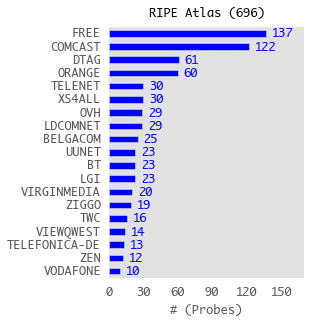

In [30]:
plt.style.use('ggplot')
plt.figure()
plt.rcParams['font.size'] = 12

xticks = [i for i in range(0, 200, 30)]
num_probes = sum(df_ra['probes'].values)

ax = df_ra.plot(kind='barh', x='nodename', y='probes', xticks=xticks,
             legend=None, figsize=(3.5,4.5), grid=False);

for idx, label in enumerate(df_ra.index):
    pos = df_ra.ix[idx][1]
    value = df_ra.ix[idx][0]
    plt.annotate(str(value), xy=(value + 5, idx), va='center', fontsize=12, color='blue')    

ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_axis_bgcolor('#E2E2E2')    
plt.xlim(0,max(xticks) - 10)
plt.xlabel('# (Probes)', fontsize=12)
plt.ylabel('')
plt.title('RIPE Atlas (%d)'%num_probes, fontsize=12, y=1.02)
plt.savefig('ripeatlas-dataset-distribution.pdf', format='pdf', bbox_inches='tight')

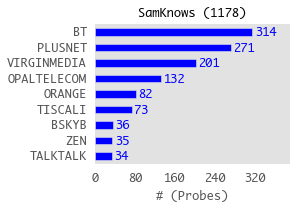

In [31]:
plt.style.use('ggplot')
plt.figure()
plt.rcParams['font.size'] = 12


xticks = [i for i in range(0, 451, 80)]
num_probes = sum(df_sk['probes'].values)

ax = df_sk.plot(kind='barh', x='nodename', y='probes', xticks=xticks,
             legend=None, figsize=(3.5,2.5), grid=False);

for idx, label in enumerate(df_sk.index):
    pos = df_sk.ix[idx][1]
    value = df_sk.ix[idx][0]
    plt.annotate(str(value), xy=(value + 5, idx), va='center', fontsize=12, color='blue')    

ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_axis_bgcolor('#E2E2E2')    
plt.xlim(0,max(xticks) - 10)
plt.xlabel('# (Probes)', fontsize=12)
plt.ylabel('')
plt.title('SamKnows (%d)'%num_probes, fontsize=12, y=1.02)
plt.savefig('samknows-dataset-distribution.pdf', format='pdf', bbox_inches='tight')